# Sieci konwolucyjne (CNN)

In [1]:
import torch
from torchvision import datasets
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F


import warnings
warnings.filterwarnings("ignore")

#### Data loader

In [2]:
class FaceKeypointsDataset(Dataset):
    
    def __init__(self, csv_file, transform = None, img_size = 96):
        self.data = pd.read_csv(csv_file).dropna()                          # Pozostaja tylko rekordy z wszystkimi keypointami
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = np.fromstring(self.data.iloc[idx, -1], sep = " ").astype(np.int).reshape(-1, self.img_size)
        keypoints = self.data.iloc[idx, :-1].values.astype(np.float32)
        sample = {'image': image, 'keypoints': keypoints}
        
        if self.transform:
            sample = self.transform(sample)
        
#         if len(image) != 96:
#             raise Exception('Error: incorect img size idx: {}'.format(idx))
        
        return sample
    
    def show_sample(self, idx):
        
        image, keypoints = self[idx]['image'], self[idx]['keypoints']
        
        if isinstance(image, torch.Tensor):
            image = image.numpy().reshape(self.img_size, self.img_size)
            
        if isinstance(keypoints, torch.Tensor):
            keypoints = keypoints.numpy()
        
        fig = plt.figure(figsize = [5, 5])
        ax = plt.subplot()
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(idx))
        ax.axis('off')

        plt.imshow(image, cmap = 'gray')
        plt.scatter(keypoints[0::2], keypoints[1::2], s = 100, marker = '.', c = 'r')

        plt.show()
        

In [3]:
class Normalize(object):
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        return {'image': image / 255., 'keypoints': keypoints}

In [4]:
class ToTensor(object):
    
    def __init__(self, size = 96):
        self.size = size
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        image = image.reshape(1, self.size, self.size)
        image = torch.from_numpy(image)
        keypoints = torch.from_numpy(keypoints)
        return {'image': image, 'keypoints': keypoints}

In [5]:
class RandomCrop(object):
    """
    Custom RandomCrop - landmarks edited. 
    
    Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        landmarks = landmarks.reshape(int(len(landmarks) / 2) , 2)
        landmarks = landmarks - [left, top]
        landmarks = landmarks.flatten()

        return {'image': image, 'keypoints': landmarks}

In [6]:
def prepare_loaders(dataset, test_size = 0.2, batch_size = 128):
    
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    th = int(test_size * len(dataset))
    test_idx, train_idx = indices[:th], indices[th:]
    
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, sampler = test_sampler)
    
    return train_loader, valid_loader

#### Definicja sieci

In [7]:
class ConvNet(nn.Module):
    def __init__(self, size = 96):
        super(ConvNet, self).__init__()
        self.conv1=nn.Conv2d(1, 32, 5) 
        self.pool1 = nn.MaxPool2d(2, 2)
        size =  (size - 5)/1 + 1
        
        self.pool = nn.MaxPool2d(2, 2)
        dim = (32, size / 2, size / 2)

        self.conv2=nn.Conv2d(dim[0], 64, 3)
        size = (dim[1] - 3) + 1
        
        self.pool2 = nn.MaxPool2d(2, 2)
        dim = (64, size/2, size/2)

        self.conv3=nn.Conv2d(dim[0], 128, 1)
        size = (dim[1] - 1) + 1
        
        self.pool3 = nn.MaxPool2d(2, 2)
        dim = (128, size / 2, size / 2)

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(int(dim[0] * dim[1] * dim[2]), 1000)
        self.fc2 = nn.Linear(1000, 30)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.reshape(x.size(0), -1)
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

#### Skrypt treningowy

In [8]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50):

    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        
        train_loss = 0.0
        test_loss = 0.0

       
        model.train() #training
        for batch in train_loader:
            
            optimizer.zero_grad()
           
            output = model(batch['image'].to(device).float() )
            
            loss = criterion(output, batch['keypoints'].to(device).float() )
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

       
        model.eval() #  evaluation
        for batch in test_loader:
            
            output = model(batch['image'].to(device).float() )
            
            loss = criterion(output, batch['keypoints'].to(device).float() )
             
            test_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        test_loss = test_loss/len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \ Test Loss: {:.6f}'
              .format(epoch+1, train_loss, test_loss))
            
    return train_losses, test_losses 

In [9]:
plt.style.use('seaborn-darkgrid')
def plot_loss(train_losses, valid_losses):

    fig, ax1 = plt.subplots(figsize = [10, 7])

    ax1.set_xlabel('epoch')
    ax1.set_ylabel('RMSE')
    ax1.plot([i for i in range(len(train_losses))], train_losses, color = 'r', label = 'train')
    ax1.plot([i for i in range(len(valid_losses))], valid_losses, color = 'g', label = 'test')
    plt.legend()
    fig.tight_layout()  
    plt.show()
              

#### Odpalenie modelu bez przeksztalen

In [10]:
%%time
batch_size = 16
test_size = 0.2
n_epochs = 100
lr = 0.001
size = 96

trs = transforms.Compose([ToTensor(size)])

face_dataset = FaceKeypointsDataset(csv_file = 'facialkeypoints/training.csv', transform = trs)

train_loader, test_loader = prepare_loaders(dataset = face_dataset, test_size = test_size, batch_size = batch_size)

device = torch.device('cpu')
model = ConvNet(size)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

train_losses, valid_losses = train(train_loader, test_loader, model, criterion, optimizer, n_epochs = n_epochs)

Epoch: 1 	Training Loss: 720.732741 \ Test Loss: 87.595489
Epoch: 2 	Training Loss: 82.474554 \ Test Loss: 63.400436
Epoch: 3 	Training Loss: 68.704267 \ Test Loss: 50.522889
Epoch: 4 	Training Loss: 52.121473 \ Test Loss: 42.849728
Epoch: 5 	Training Loss: 45.231073 \ Test Loss: 56.495110
Epoch: 6 	Training Loss: 29.566723 \ Test Loss: 11.484162
Epoch: 7 	Training Loss: 12.150332 \ Test Loss: 7.865158
Epoch: 8 	Training Loss: 9.508824 \ Test Loss: 6.805467
Epoch: 9 	Training Loss: 8.839362 \ Test Loss: 6.361929
Epoch: 10 	Training Loss: 8.059986 \ Test Loss: 6.363254
Epoch: 11 	Training Loss: 7.498026 \ Test Loss: 5.672501
Epoch: 12 	Training Loss: 7.307237 \ Test Loss: 5.704901
Epoch: 13 	Training Loss: 6.897833 \ Test Loss: 6.382873
Epoch: 14 	Training Loss: 6.812347 \ Test Loss: 6.607267
Epoch: 15 	Training Loss: 6.457741 \ Test Loss: 5.703892
Epoch: 16 	Training Loss: 6.320402 \ Test Loss: 5.615128
Epoch: 17 	Training Loss: 6.009390 \ Test Loss: 5.241425
Epoch: 18 	Training Loss: 

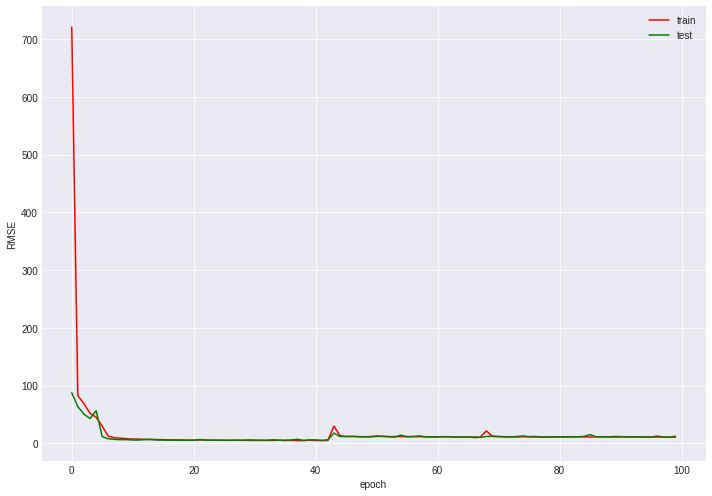

In [11]:
plot_loss(train_losses, valid_losses)

#### Odpalenie modelu z transformacjami

In [12]:
%%time
batch_size = 16
test_size = 0.2
n_epochs = 100
lr = 0.001
size = 80

trs = transforms.Compose([                                  
                            RandomCrop(size),\
                                Normalize(),\
                                 ToTensor(size)
                                  ])

face_dataset = FaceKeypointsDataset(csv_file = 'facialkeypoints/training.csv', transform = trs)

train_loader, test_loader = prepare_loaders(dataset = face_dataset, test_size = test_size, batch_size = batch_size)

device = torch.device('cpu')
model = ConvNet(size)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

train_losses, valid_losses = train(train_loader, test_loader, model, criterion, optimizer, n_epochs = n_epochs)

Epoch: 1 	Training Loss: 144.482034 \ Test Loss: 32.621212
Epoch: 2 	Training Loss: 24.549839 \ Test Loss: 14.590473
Epoch: 3 	Training Loss: 15.446119 \ Test Loss: 11.591460
Epoch: 4 	Training Loss: 12.815383 \ Test Loss: 10.788511
Epoch: 5 	Training Loss: 12.226276 \ Test Loss: 10.697608
Epoch: 6 	Training Loss: 11.481481 \ Test Loss: 9.022158
Epoch: 7 	Training Loss: 11.251268 \ Test Loss: 8.306691
Epoch: 8 	Training Loss: 10.770105 \ Test Loss: 9.365954
Epoch: 9 	Training Loss: 9.948934 \ Test Loss: 9.081212
Epoch: 10 	Training Loss: 9.998845 \ Test Loss: 9.089600
Epoch: 11 	Training Loss: 9.500524 \ Test Loss: 8.250472
Epoch: 12 	Training Loss: 9.394919 \ Test Loss: 7.472529
Epoch: 13 	Training Loss: 8.386264 \ Test Loss: 10.883363
Epoch: 14 	Training Loss: 8.475867 \ Test Loss: 6.738029
Epoch: 15 	Training Loss: 7.747358 \ Test Loss: 7.335586
Epoch: 16 	Training Loss: 8.625982 \ Test Loss: 5.819426
Epoch: 17 	Training Loss: 7.900410 \ Test Loss: 7.529839
Epoch: 18 	Training Loss:

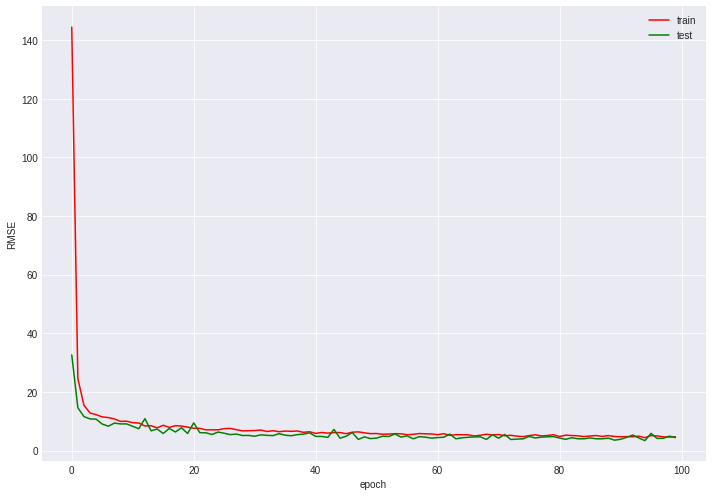

In [13]:
plot_loss(train_losses, valid_losses)